# Workshop 3: Let's get our model! / 実際にモデルを作りましょう！

**🎨 チーム/Team __**

`上記の下線部にチーム番号を記入してください` \
`Add your team number above`

**👥 メンバー/Authors**

`50音順でチームメンバーの氏名を全て記載してください`\
`Add your names here (alphabetically)`

**🎯 このワークショップの目標/Goals of this Workshop**
1. 訓練データとテストデータを適当に分割できるようになる
2. 作成したモデルの評価に用いる性能指標(メトリクス)を定義できるようになる
3. 以下の機能を備えた機械学習モデルを開発する
  - $SaO_2$の値を予測する (回帰問題)
  - $SaO_2$と$SpO_2$の差を予測する (回帰問題)
  - 潜在性低酸素血症を検知する (分類問題)

  (モデルは線形でも非線形でもよい)
4. パラメータの最適化手法の一つであるグリッドサーチを実装できるようになる
5. 回帰問題や分類問題について最も寄与する特徴量がなんであったか評価できるようになる

<br/>

1. Understand the best way to split the data into train and test
2. Define the performance metrics that you are going to use in the evaluation of your model
3. Develop a machine learning (ML) model to either:
  - predict $SaO_2$ values -> regression
  - predict the gap between $SaO_2$ and $SpO_2$ -> regression
  - detect cases of Hidden Hypoxemia (HH) -> classification

  The developed model can either be linear or non-linear.
4. Implement grid-search to further optimize parameters.
5. Assess what were the most relevant features for the regression/classification.



**✏️ 最終目標 / Expected Deliverables**
 - 性能評価指数や特徴量の重要性が正しく理解した上でモデルを実際に作成すること

<br/>

 - Developed models with the performance metrics and feature importance properly reported.



**❗ 注意事項 / Highlighted Pitfall(s)**
- リーケージ(Data Leakage)を起こさないようにしましょう
- 適切でないモデル評価の指標(メトリクス)を用いないようにしましょう
- 与えられた基本モデルと比べて性能が向上しないケースや学習が進んでいないケースに注意しましょう
- あまりにも複雑なモデルは作成しないようにしましょう

<br/>

- Outcome leakage
- Suboptimal metrics for model evaluation
- No improvement compared to the presented baseline / Models not learning
- Overly complex models

## 1. 準備 / Setup Environment

作成するモデルに対して、あなたがより慣れている他のライブラリがある場合は追加しても構いません。
<br/>
You can add more libraries if you are familiar with them for your own model.

In [ ]:
# If your datasets exist in Google Drive, you need to mount Google Drive to access files
# If you upload your datasets directly to Google Colab, you don't need it.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installs

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install yellowbrick

In [ ]:
# for Japanese characters in matplotlib
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120258 sha256=d9a54e0c12d55b78ba49a8dd1538ae7f44ecc3093fedcbd2fdbed57ddc1a54fb
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


### Imports

In [ ]:
# Data reading in Dataframe format and data preprocessing
import pandas as pd
pd.set_option("display.max_columns", 160)
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Creation
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Dataset Processing
from sklearn import datasets, linear_model, metrics
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Model Development
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.classifier import ClassificationReport, ClassPredictionError
from yellowbrick.regressor import ResidualsPlot, PredictionError

# Feature Importance
import shap

# Japanize Matplotlib
import japanize_matplotlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 2. 前処理 / Preprocess

###### ✏️ work_dirを正しく修正し、データセットを取ってきましょう
✏️ Set your path to the datasets, and fetch them

In [ ]:
# set pathes
train_path = "/content/drive/MyDrive/workshops_preparation/for_japan/solutions/output/workshop_2_train.csv"
test_path = "/content/drive/MyDrive/workshops_preparation/for_japan/solutions/output/workshop_2_test.csv"

# fetch dataset
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [ ]:
# check dataset (Do not peep test data)
df_train.head(2)

,language,inr,ventilation_status,FiO2,creatinine,albumin,aniongap,anchor_age,bun,rrt,gender,invasive_vent,pt,CCI,delta_vent_start,ph,chloride,SpO2,insurance,hidden_hypoxemia,bilirubin_total,delta_SpO2,delta_sofa_coag,rdw,delta_sofa_cns,subject_id,delta_sofa_cv,race_group,mcv,BMI,SOFA_admission,norepinephrine_equivalent_dose,SaO2,stay_id,sofa_coag,mchc
0,Proficient,1.1,NonInvasiveVent,0.0,0.0,3.5,0.0,68,0.0,0.0,F,0,12.4,5,-4.0,0.0,0.0,89.0,Medicare,0,0.2,-4.0,0.0,0.0,-64.0,10001884,-4.0,Black,0.0,26.370238,8,0.0,90.0,37510196,None,0.0
1,Proficient,1.1,InvasiveVent,0.0,0.5,0.0,11.0,80,25.0,0.0,F,1,11.8,6,-1820.0,0.0,110.0,100.0,Medicare,0,0.1,-3.0,0.0,14.6,-80.0,10002428,-20.0,White,98.0,0.000000,10,0.0,98.0,38875437,None,31.5


[Variable Dictionary (GitHub Link)](https://github.com/TokyoDatathon2023/notebooks/blob/main/variable_dictionary.md): データフレームで使用されている変数の一覧と簡易的な説明

### 2.1 エンコード / Encoding

Backgroundの機械学習モデルは私たちの持っているデータをモデル化し、そこからパターンを見つけます。この処理は数値的な値にしか適用できません。つまり、カテゴリ変数は数値的な値に変換しなくてはならないのです。

カテゴリ変数には次の三種類が存在します。
- バイナリ変数 (Binary Variables):
> バイナリ変数は1と0の二つの値を表現することができる。例えば、対象が特定のグループに対して所属(1)、非所属(0)といったことを表現するのに用いられる。

<br />


- 順序変数 (Ordinal Variables):
> 順序変数はある特定の順番を持っており、ラベルによるエンコード(Label Encoding)をすることによって数値的な値に表現しなおすことができる。例えば、High, Medium, Lowといった三つのデータは順序変数である。なぜなら、これらは決まった順序を持つので、それぞれ3, 2, 1という数値的な値に表現しなおすことができるからだ。


<br />

- 名義変数 (Nominal Variables):
> 名義変数は決まった順序を持たない。従ってこの種の変数にはラベルによるエンコードが適していない。代わりに、ワンホットエンコードを行うのが良い。

<br />

Since the machine learning model in the background models and finds patterns in our data. It only supports numeric values. For this reason, categorical variables must be coded to numeric values.

Categorical variables can be of 3 types:
- Binary variables: Binary variables can be represented with two values, 1 and 0. Examples are whether or not the variable belongs to a group.
- Ordinal variables: Ordinal variables are a type of variables that have a specific order and can be represented with numeric variables through a label encoder. An example is High, Medium, and Low which can be represented as 3, 2, 1.
- Nominal variables: Nominal variables are categorical variables that do not have a defined order, for these variables it is not recommended to use a label encoder, it is better to use one hot encoder in these cases.

###### ✏️ どのカテゴリ変数を持っているでしょうか？ / Which type of categorical variables we have?

なお、必ずしも全ての種類に相当する変数がなくてはならないというわけではありません。\
Not necessarily must have variables of each type.

> **ヒント / Hint**: \
> 次の`check_variable_kind`を使って調べてみましょう。\
> Use `check_variable_kind` to check the kinds of variables.

* バイナリ変数 / The binary variables are: \
(ここに当てはまる変数を書いてください / here)



<br />

* 順序変数 / The ordinal variables are: \
(ここに当てはまる変数を書いてください / here)



<br />

* 名義変数 / The Norminal variables are: \
(ここに当てはまる変数を書いてください / here)

In [ ]:
def check_variable_kind(df):
    # check per column
    for col in df.columns:
        # show the name and the num of unique variables
        print(f"Column: {col} | {df[col].unique().size} unique values")

        # get unique values
        unique_sample = df[col].unique().tolist()
        print("[  ", end="")
        if len(unique_sample) < 10:
            # when the num of kinds is less 10
            for u in unique_sample: print(f"{u}  ", end="")
        else:
            # otherwise
            for i in range(5): print(f"{unique_sample[i]}  ", end="")
            print("\n\t... ", end="")
            for i in range(5): print(f"{unique_sample[-(5-i)]}  ", end="")
        print("]\n")

In [ ]:
# check the kinds of variables
check_variable_kind(df_train)

Column: language | 2 unique values
[  Proficient  Limited Proficiency  ]

Column: inr | 71 unique values
[  1.1  1.5  1.3  0.0  1.2  
	... 7.9  0.7  21.8  5.8  22.6  ]

Column: ventilation_status | 6 unique values
[  NonInvasiveVent  InvasiveVent  None  SupplementalOxygen  HFNC  Tracheostomy  ]

Column: FiO2 | 18 unique values
[  0.0  50.0  40.0  70.0  30.0  
	... 45.0  28.0  55.0  23.0  95.0  ]

Column: creatinine | 106 unique values
[  0.0  0.5  0.7  0.8  0.6  
	... 12.1  8.6  10.7  7.3  7.9  ]

Column: albumin | 43 unique values
[  3.5  0.0  3.7  3.4  3.2  
	... 5.0  1.5  1.7  1.3  1.1  ]

Column: aniongap | 46 unique values
[  0.0  11.0  10.0  7.0  14.0  
	... 36.0  48.0  41.0  47.0  50.0  ]

Column: anchor_age | 73 unique values
[  68  80  78  76  38  
	... 18  34  33  27  36  ]

Column: bun | 152 unique values
[  0.0  25.0  21.0  17.0  16.0  
	... 117.0  148.0  170.0  207.0  112.0  ]

Column: rrt | 3 unique values
[  0.0  1.0  None  ]

Column: gender | 2 unique values
[  F  M  ]


###### ✏️ バイナリ変数のエンコード / Encode binary variables

機械学習のモデルが理解できるのは数字だけです。従って、バイナリ変数は0, 1でエンコードしましょう。\
該当する変数列の値を0, 1で置き換えてください。

Machine learning models only understand numbers, so binary variables must be encoded as 1s and 0s. Replace the values in those columns with 1s and 0s

>**ヒント / Hint**: \
> `df.replace()`を使う
>
> you can use `df.replace()` to do that

In [ ]:
for col in df_train.columns:
    if (df_train[col].nunique() == 2) & (set(df_train[col].unique()) != {0, 1}):
        print(f"Column: {col}, Unique values: {df_train[col].unique()}")

Column: language, Unique values: ['Proficient' 'Limited Proficiency']
Column: gender, Unique values: ['F' 'M']


In [ ]:
# when replacing A to B
# df.replace(A, B)

for df in [df_train, df_test]:
  df["gender"].replace({"M": 0, "F": 1}, inplace=True)
  df["language"].replace({"Proficient": 0, "Limited Proficiency": 1}, inplace=True)

###### ✏️ 順序変数のエンコード /  Encode ordinal variables

`label_encoder ` を使って順序変数を数値にエンコードしましょう。

You can use the function `label_encoder ` to encode the ordinal variables as numeric variables.

> **Hint**:

> **ヒント / Hint**: \
> 変数の中には一見すると数値へのエンコードが既に終わっているように思えるものがあるかもしれません。しかしそういった変数の中には欠損値の補完として`None`が紛れ込んでいる恐れがあります。この`None`を数値にエンコードするには`df.replace`を用いましょう。
>
>Some variables are already numerical, but have 'None' due to the imputation. You can use `df.replace` to convert that 'None' to numerical

In [ ]:
def label_encoder(df_train, cols, df_test=None):
  """
  Scikit-learn の LabelEncoder を用いて Pandas の DataFrame に含まれているカテゴリ変数(順序変数)をエンコードする関数.

  引数:
  df_train - Pandas DataFrame. エンコードするDataFrame.
  cols - list. エンコードされるカラム名のリスト.
  df_test (オプショナル) - Pandas DataFrame. 同時にエンコードするDataFrame.

  返り値:
  以下を含むタプル.
  - エンコードされた df_train
  - 使用した LabelEncoders の辞書
  - エンコードされた df_test (オプショナル)
  """
  encoders = {}
  for col in cols:
    encoders[col] = LabelEncoder()
    df_train[col] = encoders[col].fit_transform(df_train[col])
    if df_test is not None:
      df_test[col] = encoders[col].transform(df_test[col])

  if df_test is not None:
    return df_train, df_test, encoders
  else:
    return df_train, encoders


In [ ]:
# Code here!
df_train["rrt"] = df_train["rrt"].replace("None", 0).astype(float)
df_test["rrt"] = df_test["rrt"].replace("None", 0).astype(float)

df_train["sofa_coag"] = df_train["sofa_coag"].replace("None", -1).astype(float)
df_test["sofa_coag"] = df_test["sofa_coag"].replace("None", -1).astype(float)

df_train, df_test, encoders = label_encoder(df_train, ['rrt', 'sofa_coag'], df_test=df_test)

###### ✏️ 名義変数のエンコード / Encode nominal variables

以下の`column_to_one_hot`を用いて名義変数を[ワンホット(one-hot)表記](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)にエンコードしましょう。

You can use the function `column_to_one_hot` to encode the nominal variables to a [one-hot representation](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

In [ ]:
def column_to_one_hot(df_train, column, df_test=None):
  # Generate a one-hot representation of the values in the column
  train_one_hot = pd.get_dummies(df_train[column], dtype=int, drop_first=True)
  # add the one-hot encoded columns to the DataFrame
  df_train = pd.concat([df_train, train_one_hot], axis=1)
  # drop the original column
  df_train = df_train.drop(column, axis=1)

  if df_test is not None:
    test_one_hot = pd.get_dummies(df_test[column], dtype=int, drop_first=True)

    # Add missing columns in test data
    missing_cols = set(train_one_hot.columns) - set(test_one_hot.columns)
    for c in missing_cols:
      test_one_hot[c] = 0

    # Ensure the order of column in the test set is in the same order than in train set
    test_one_hot = test_one_hot[train_one_hot.columns]
    df_test = pd.concat([df_test, test_one_hot], axis=1)
    df_test = df_test.drop(column, axis=1)
    return df_train, df_test
  else:
    return df_train

In [ ]:
def convert_categorical_column_to_one_hot(df_train, df_test, column_name, replace_target):
    # Modify the target value in the column
    replace_dict = {replace_target: f"{column_name}_{replace_target}"}

    df_train[column_name] = df_train[column_name].replace(replace_dict)
    df_test[column_name] = df_test[column_name].replace(replace_dict)

    # Convert the column into one-hot encoding
    df_train, df_test = column_to_one_hot(df_train=df_train, column=column_name, df_test=df_test)

    return df_train, df_test

In [ ]:
df_train, df_test = convert_categorical_column_to_one_hot(df_train, df_test, "ventilation_status", "None")
df_train, df_test = convert_categorical_column_to_one_hot(df_train, df_test, "race_group", "Other")
df_train, df_test = convert_categorical_column_to_one_hot(df_train, df_test, "insurance", "Other")

### 2.2 データの正規化 / Data Normalization

多くの機械学習モデルには、モデルに入力する特徴量のスケールが大きく影響してきます。 \
そのため、パイプラインに用いる値の大きさを正規化することが大切です。

最も一般的な手法の一つはデータの標準化ですが、対象となるユースケースやモデルによっては不適当である可能性があり、考慮して手法を決定することが必要です。<[詳細はこちら](https://scikit-learn.org/stable/modules/preprocessing.html)>

データセットには幾つかのタイプの変数が含まれていることがあり、それを考慮することが重要です。

> * カテゴリー変数 (例: [花の種類] ひまわり, たんぽぽ, チューリップ) \
> * 連続型の変数 (例: [身長] 185cm, 160cm, 172cm) \
> * バイナリ変数 (例: 0, 1)

例えば、カテゴリ変数とバイナリ変数についてデータの標準化を行うことは往々にして得策ではないでしょう。\
このように、異なるタイプの変数を区別し、それぞれの変数について適当な正規化方法を適用することが重要です。

<br/>

Many machine learning models are directly influenced by the scale of the features that you input to the model. Therefore, it is important to normalize the scale of values used in your pipeline.

One of the most common methods used is data standardization, but the decision should be taken considering the specific use case or model that you are developing. If you are curious, you can further read about this topic [here](https://scikit-learn.org/stable/modules/preprocessing.html).

It is important to consider that in a dataset one might have several types of variables: categorical, continuous, binary. For both categorical and binary variables, it is not a good practice to apply standardization methods. Therefore, it is important to distinguish the different type of variables that one might have and apply normalization methods only to those that make sense.

✏️ 正規化を行う前に、予測する項目を X_train と X_test から取り除き y_train や y_test に格納しましょう<br>
Split your labels from the remaining dataset

In [ ]:
# labels we are going to predict
label_cols=['hidden_hypoxemia', 'SaO2']
id_col = ["subject_id", "stay_id"]

# train dataset
y_train = df_train[label_cols]
X_train = df_train.drop(columns=label_cols + id_col)

# test dataset
y_test = df_test[label_cols]
X_test = df_test.drop(columns=label_cols + id_col)

In [ ]:
# check train data
y_train.head(2)

,hidden_hypoxemia,SaO2
0,0,90.0
1,0,98.0


In [ ]:
X_train.head(2)

,language,inr,FiO2,creatinine,albumin,aniongap,anchor_age,bun,rrt,gender,invasive_vent,pt,CCI,delta_vent_start,ph,chloride,SpO2,bilirubin_total,delta_SpO2,delta_sofa_coag,rdw,delta_sofa_cns,delta_sofa_cv,mcv,BMI,SOFA_admission,norepinephrine_equivalent_dose,sofa_coag,mchc,InvasiveVent,NonInvasiveVent,SupplementalOxygen,Tracheostomy,ventilation_status_None,Black,Hispanic,White,race_group_Other,Medicare,insurance_Other
0,0,1.1,0.0,0.0,3.5,0.0,68,0.0,0,1,0,12.4,5,-4.0,0.0,0.0,89.0,0.2,-4.0,0.0,0.0,-64.0,-4.0,0.0,26.370238,8,0.0,0,0.0,0,1,0,0,0,1,0,0,0,1,0
1,0,1.1,0.0,0.5,0.0,11.0,80,25.0,0,1,1,11.8,6,-1820.0,0.0,110.0,100.0,0.1,-3.0,0.0,14.6,-80.0,-20.0,98.0,0.000000,10,0.0,0,31.5,1,0,0,0,0,0,0,1,0,1,0


In [ ]:
# fetch X_train for binary variables
binary_variables = [feat for feat in X_train.columns if X_train[feat].unique().size == 2]

In [ ]:
# check fetched binary variables
binary_variables

['language',
 'rrt',
 'gender',
 'invasive_vent',
 'InvasiveVent',
 'NonInvasiveVent',
 'SupplementalOxygen',
 'Tracheostomy',
 'ventilation_status_None',
 'Black',
 'Hispanic',
 'White',
 'race_group_Other',
 'Medicare',
 'insurance_Other']

In [ ]:
# split variables into continuous ones and binary or categorical ones
X_train_continuous = X_train.drop(columns=binary_variables)
X_test_continuous = X_test.drop(columns=binary_variables)
X_train_binary = X_train[binary_variables]
X_test_binary = X_test[binary_variables]

In [ ]:
# create StandardScaler instance
scaler = StandardScaler()

# fit and transform the train continuous variables
X_train_preprocessed = scaler.fit_transform(X_train_continuous)

# check preprocessed train continuous variables (Do not peep test ones)
pd.DataFrame(X_train_preprocessed, columns=X_train_continuous.columns)

,inr,FiO2,creatinine,albumin,aniongap,anchor_age,bun,pt,CCI,delta_vent_start,ph,chloride,SpO2,bilirubin_total,delta_SpO2,delta_sofa_coag,rdw,delta_sofa_cns,delta_sofa_cv,mcv,BMI,SOFA_admission,norepinephrine_equivalent_dose,sofa_coag,mchc
0,0.068199,-0.268808,-0.852397,0.761169,-1.259823,0.213021,-0.910245,0.112293,-0.085546,0.501637,-0.103749,-1.531274,-2.066923,-0.301781,0.547986,0.617718,-1.464853,-0.525381,0.275325,-1.513116,0.179646,0.049864,-0.431401,-1.051991,-1.517305
1,0.068199,-0.268808,-0.477124,-1.269359,0.142230,1.046161,0.171664,0.049342,0.300601,0.199057,-0.103749,0.764152,0.798010,-0.327932,0.893592,0.617718,0.486818,-0.794606,-2.089161,0.823831,-1.802884,0.569178,-0.431401,-1.051991,0.538906
2,0.499849,-0.268808,-0.327015,0.877200,0.014770,0.907304,-0.001441,0.531970,-0.857840,0.462148,-0.103749,0.764152,0.798010,-0.249479,1.584803,0.612049,0.219466,0.551522,0.718667,0.704599,-0.295590,-1.248420,-0.400871,-0.154327,0.682514
3,0.499849,-0.268808,-0.327015,0.877200,0.014770,0.907304,-0.001441,0.531970,-0.857840,0.440155,-0.103749,0.764152,0.798010,-0.249479,-1.180043,-0.136239,-1.464853,0.332776,-1.054698,-1.513116,-0.295590,-1.248420,-0.400871,-0.154327,-1.517305
4,0.499849,-0.268808,-0.852397,0.877200,-1.259823,0.907304,-0.910245,0.531970,-0.857840,0.395001,-0.103749,-1.531274,0.798010,-0.249479,0.547986,0.617718,0.500185,0.551522,0.866447,0.633060,-0.295590,-1.248420,-0.385721,-1.051991,0.708625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11826,-1.118838,-0.268808,-0.852397,-1.269359,-1.259823,-0.134121,-0.910245,-1.188706,0.686748,0.500804,-0.103749,-1.531274,-0.504232,0.247390,-0.834438,0.617718,-1.464853,0.551522,-2.975843,-1.513116,0.249805,0.309521,-0.393354,-1.051991,-1.517305
11827,0.931499,-0.268808,0.048258,-1.269359,1.289364,-0.134121,1.080468,0.951647,0.686748,0.364676,-0.103749,0.743285,0.537562,-0.354083,0.893592,0.600711,0.887846,0.501042,0.423106,0.489981,0.249805,0.309521,-0.431401,1.640999,0.800012
11828,-1.118838,3.279652,-0.101851,0.761169,1.034445,-0.897832,-0.217823,-1.188706,-0.857840,0.370675,9.526562,0.597212,-0.243784,-0.301781,-1.525649,0.561029,0.433347,-1.635936,-0.611357,0.656906,0.693347,-0.729107,-0.374234,1.640999,0.558489
11829,0.176111,-0.268808,-0.327015,-1.269359,0.142230,0.074164,-0.304376,0.185737,-0.857840,0.481143,-0.103749,0.847622,0.798010,-0.275630,1.584803,0.271918,0.326407,-0.474901,0.718667,0.609213,0.434324,-1.508077,-0.404688,-0.154327,0.565016


In [ ]:
# apply preprocessor to train continuous variables (Do not peep the preprocessed ones)
X_test_preprocessed = scaler.transform(X_test_continuous)

前処理(標準化)を行った連続型の変数とバイナリ変数を結合し、モデルに与えます。

<br/>

Join the processed continuous variables with the binary ones to then feed to the model.

In [ ]:
# join
X_train_processed = pd.concat([df_train["subject_id"], X_train_binary, pd.DataFrame(X_train_preprocessed, columns=X_train_continuous.columns)], axis=1, join='inner')
X_test_processed = pd.concat([df_test["subject_id"], X_test_binary, pd.DataFrame(X_test_preprocessed, columns=X_test_continuous.columns)], axis=1, join='inner')

注: データに処理を加えた場合、処理後の分散をしっかりと調べ、適用した前処理が意味を持ち、期待した効果をもたらしているかどうかを確認することが重要である。

<br/>

Note: After transforming your data, it is important to further explore it's distribution and ensure that the transformations applied make sense and resulted on what was expected.

###### ✏️ データの正規化方針を自身で考え、実装してみよう /  Implement your own data normalization strategy

In [ ]:
# Code here!


# Check your normalization, e.g. summary statistics, histograms, scatter plots, etc.



## 3. 機械学習パイプラインの実装 / Implement ML Pipeline

以降の処理では、パイプラインを使用してデータの前処理からモデルの構築まで一貫して実行可能な実装を試みましょう。訓練データ、テストデータを再度読み込むようにしてください。

In subsequent processes, try to use a pipeline to implement a consistent implementation that can run from data preprocessing to model building. Be sure to reload the training and test data.

In [ ]:
# read dataset again to avoid duplicative encoding
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

### 回帰(regression)と分類(classification)に対応したラベル分け / Get label vectors for both possibilities: regression and classification

回帰を行いたいのか、分類を行いたいのかによって、学習の際に使用する正解ラベルは異なります。
回帰の場合は連続変数である$SaO_{2}$を、分類の場合は潜在性低酸素血症のクラスを定義する必要があります。

<br/>
If you want to use regression or classification, the labels used to train the model will be different. In the case of regression, you will have a numerical variables with SaO2 values, whereas in classification you need to define classes for hidden hypoxemia.

In [ ]:
# for regression
y_train_r = df_train[['SaO2']].values
y_test_r = df_test[['SaO2']].values

# check y_train_r (Do not peep y_test_r)
print(f"Size: {len(y_train_r)} * {len(y_train_r[0])}")
for i in range(5):
    print(f"{i}: {y_train_r[i]}")
print("...")

Size: 11831 * 1
0: [90.]
1: [98.]
2: [99.]
3: [98.]
4: [98.]
...


In [ ]:
# for classification
y_train_c = df_train[['hidden_hypoxemia']].values
y_test_c = df_test[['hidden_hypoxemia']].values

# check y_train_c (Do not peep y_test_c)
print(f"Size: {len(y_train_c)} * {len(y_train_c[0])}")
for i in range(5):
    print(f"{i}: {y_train_c[i]}")
print("...")

Size: 11831 * 1
0: [0]
1: [0]
2: [0]
3: [0]
4: [0]
...


###### ✏️ 実装する機械学習手法に沿って、他に必要なラベルを定義する / Define label vectors for chosen ML approaches

In [ ]:
# Code here!

### 3.1 ナイーブな手法で予測を行うモデル実装 / Naive Model Implementation

二つのクラス(潜在性低酸素血症であるか否か)について、訓練データの中で多い方をそのまま予測結果として学習させた場合、モデルの精度はどうなるでしょうか。

この場合、潜在性低酸素血症でないデータの方が多ければ予測ベクトルの値は全て0であり、潜在性低酸素血症であるデータの方が多ければ予測ベクトルの値は全て1となります。

このような、全ての患者について最も可能性の高いクラスだと予想するモデル(以下 ナイーブモデル)を訓練データセットを用いて作成してみましょう。

<br/>
What would our accuracy be if we predicted the most likely class? In this case, our prediction would simply be 1 or 0 for every patient. Using our training dataset we can create a naive model that predicts the most likely class for every patient

✏️ ナイーブな手法をテストして、その結果をパフォーマンスのベースラインとしよう / Test a naive approach to have a performance baseline

In [ ]:
# トレーニングセットのクラスラベル0と1の数を比較して、どちらが多いかを判定する
if np.sum(y_train_c==0) > np.sum(y_train_c==1):
    # クラスラベル0が多い場合、常にクラスラベル0を予測する
    y_preds_cc = [0 for _ in range(len(y_test_c))]
else:
    # クラスラベル1が多い場合、常にクラスラベル1を予測する
    y_preds_cc = [1 for _ in range(len(y_test_c))]

In [ ]:
# Code here!
# Check accuracy score
accuracy_score = np.mean(y_preds_cc == y_test_c)
print("Accuracy: {:.6f}".format(accuracy_score))

Accuracy: 0.982765


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Compute F1 score
f1 = f1_score(y_test_c, y_preds_cc)

print("F1 Score for Naive Model: {:.6f}".format(f1))


F1 Score for Naive Model: 0.000000


### 3.2 回帰モデルを作ってみよう

ここでは、訓練データを使用して、与えられた特徴量から$SaO_{2}$を予測する回帰モデルを作成し、テストデータの$SaO_{2}$を予測してみます。

#### 3.2.1 線形回帰のベースライン / Linear Regression Baseline

最も簡単な機械学習モデルの一つが**線形回帰モデル**です。 \
これは、ターゲットとなる変数が特徴量の線形和で表されることを前提としたモデルです。

この手法は、多くの問題においてかなり強力なベースラインです。 \
手法が単純であるおかげで、特徴数の数が多い場合でも、非常に早くフィッティングを行うことができます。

一般的に、特徴量、前処理、そして推定値のフィッティングをシングルパイプラインでまとめて行った方が、データの変換、フィッティング、予測がより容易となります。

さらに、訓練データに対して fit 関数を呼び出すことにより、モデルを学習させることができます。ここでは、 pipeline を使用して、データの正規化から一貫してモデルの学習までを実行してみましょう。

<br/>

On of the easiest Machine Learning model is **linear regression**. It assumes that the target variable can be written as a linear combination of the features.

In many problems, this solution can be a very strong baseline. Thanks to its simplicity, it can be fitted very quickly even when the number of features is high.

In general, wrapping together the features, preprocessing and fitting the estimator in a single pipeline makes it easier to transform, fit and predict the data.

We train the model by calling the fit function on the train data.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        if 'rrt' in X_.columns:
            X_["rrt"] = X_["rrt"].replace({"None": 0}).astype(float)
        if 'sofa_coag' in X_.columns:
            X_["sofa_coag"] = X_["sofa_coag"].replace({"None": -1}).astype(float)
        return X_

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# 前処理のためのパイプラインを作成する
binary_vars = ['invasive_vent', 'rrt']
categorical_vars = ['gender', 'insurance', 'race_group', 'language', 'ventilation_status']
ordinal_vars = ['sofa_coag']
continuous_vars = [col for col in df_train.columns if col not in binary_vars + categorical_vars + ordinal_vars + ['subject_id', 'stay_id', 'SaO2', 'hidden_hypoxemia']]

X_train = df_train.drop(columns=['SaO2', 'subject_id', 'stay_id', 'hidden_hypoxemia'])
X_test = df_test.drop(columns=['SaO2', 'subject_id', 'stay_id', 'hidden_hypoxemia'])

preprocessor = ColumnTransformer(
    transformers=[
        ('bin', 'passthrough', binary_vars),
        ('cat', OneHotEncoder(drop='first'), categorical_vars),
        ('ord', OrdinalEncoder(), ordinal_vars),
        ('num', StandardScaler(), continuous_vars)
    ]
)

In [ ]:
# 前処理と線形回帰を組み合わせたパイプライン
linear_pipeline_regression = Pipeline([
    ('custom_transform', CustomTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# モデルの訓練
linear_pipeline_regression.fit(X_train, y_train_r.ravel())

Pipeline(steps=[('custom_transform', CustomTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('bin', 'passthrough',
                                                  ['invasive_vent', 'rrt']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'insurance',
                                                   'race_group', 'language',
                                                   'ventilation_status']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['sofa_coag']),
                                                 ('num', StandardScaler(),
                                                  ['inr', 'FiO2', 'creatinine',
                                                   'albumin', 'aniongap',
                                                   'anchor_age', 'bun', 'pt',
                                                   'CCI', 'delta_vent_start',
                                                   'ph', 'chloride', 'SpO2',
                                                   'bilirubin_total',
                                                   'delta_SpO2',
                                                   'delta_sofa_coag', 'rdw',
                                                   'delta_sofa_cns',
                                                   'delta_sofa_cv', 'mcv',
                                                   'BMI', 'SOFA_admission',
                                                   'norepinephrine_equivalent_dose',
                                                   'mchc'])])),
                ('regressor', LinearRegression())])

##### 線形回帰モデルの解釈 / Interpretation:

線形モデルは特徴量一つにつき一つの重みを与えるため、係数を可視化することによって、線形モデルが私たちのターゲットとなる共変量をどのようにモデル化したのかを簡単に調べることができます。

<br/>

Because the linear model gives one weight to each feature, we can easily explore how it modeled our target covariate by visualizing the coefficients.

In [ ]:
print('線形(回帰)モデルの係数 / Examine regression coefficients:')
feature_names = linear_pipeline_regression.named_steps['preprocessor'].get_feature_names_out()
linear_coefficients = pd.DataFrame(
    linear_pipeline_regression.named_steps['regressor'].coef_,  # no need to reshape
    index=feature_names,
    columns=['coefficient']
)

# 係数の絶対値に基づいて並び替え
linear_coefficients = linear_coefficients.reindex(linear_coefficients.coefficient.abs().sort_values(ascending=False).index).T

linear_coefficients


線形(回帰)モデルの係数 / Examine regression coefficients:


,bin__invasive_vent,num__SpO2,cat__ventilation_status_InvasiveVent,cat__ventilation_status_None,cat__ventilation_status_SupplementalOxygen,cat__ventilation_status_NonInvasiveVent,num__mchc,num__mcv,cat__ventilation_status_Tracheostomy,cat__race_group_Hispanic,cat__race_group_Black,cat__insurance_Other,cat__race_group_White,num__ph,num__rdw,cat__language_Proficient,num__SOFA_admission,num__anchor_age,cat__race_group_Other,num__inr,num__aniongap,cat__insurance_Medicare,num__delta_sofa_cv,num__FiO2,num__CCI,num__BMI,num__delta_vent_start,num__bun,num__creatinine,num__chloride,num__delta_SpO2,ord__sofa_coag,bin__rrt,num__bilirubin_total,num__delta_sofa_cns,num__delta_sofa_coag,num__norepinephrine_equivalent_dose,num__pt,num__albumin,cat__gender_M
coefficient,2.617252,1.840582,-1.212225,1.065866,0.816101,0.814257,0.758018,-0.665289,-0.520104,0.29449,-0.290085,0.246957,0.204411,-0.18564,-0.170962,0.16852,-0.167554,0.166446,0.137839,0.112885,0.104047,0.088597,0.077278,-0.072924,-0.066576,-0.05794,0.054294,0.052528,-0.043263,-0.041381,-0.037728,0.03754,-0.035369,-0.030508,0.027078,0.017081,-0.016562,-0.01603,0.015114,0.008331


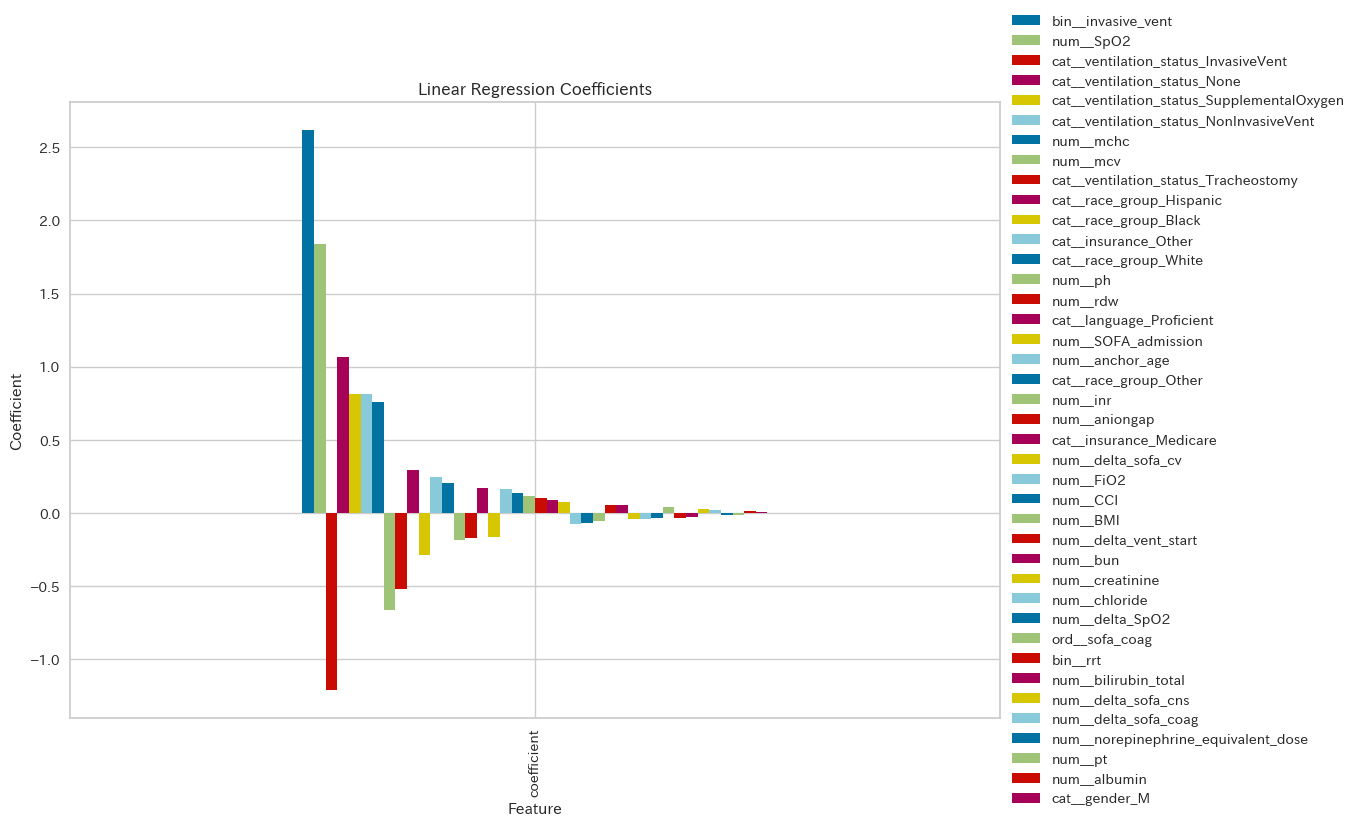

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
linear_coefficients.plot(kind='bar', ax=ax)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Linear Regression Coefficients')
plt.show()


✏️ 確認した係数の中で不思議に感じたものはありませんでしたか？ / Don't you see anything strange with some of these coefficients ?

<br/>

例えば、ほとんど0に近い(寄与しない)係数があったり、直感にそぐわない符号の係数があったり...

それらの変な係数は、複数の特徴量(説明変数)が互いに高い相関(線形関係)を持ってしまうことで生じる、多重共線性(multicollinearity)という現象が原因です。

このように線形モデルに対して冗長な情報(特徴量)を与えてしまうと、不正確でノイズの混じった係数を予測するようになってしまいます。

<参考: [線形モデルの限界について](https://inria.github.io/scikit-learn-mooc/python_scripts/linear_models_regularization.html)>


この問題に対するシンプルな解決方法は、モデルに対して極端な係数を取らせないように強制する(正則化)ことです。

次のモデルではリッジ回帰と呼ばれる正則化手法を採用しています。
> **リッジ(Ridge)回帰** \
> 学習中に用いられる損失(\*)に係数の二乗に比例する項を追加することによって、モデルが絶対値の大きな係数を採用しなくなることを狙った手法 \
> (\*損失: モデルの性能を図る指標の一つ。この値が大きいほど予測値が本来の値から離れている。)

<br/>

These weird coefficients are caused by multiple features measuring almost the same thing --a phenoma called multi-colinearity. Giving redundant information to a linear model, makes it predict unprecise and noisy coefficients.
You can learn more about [the limitations of the linear model here](https://inria.github.io/scikit-learn-mooc/python_scripts/linear_models_regularization.html).

A simple solution is to force the model to avoid extreme coefficients, by adding a *regularization*. The subsequent model is called a Ridge regression.

#### 3.2.2 Ridge 回帰

リッジ回帰を用いて算出した回帰係数を見てみましょう。\
先ほどの物に比べて筋が通っているように見えると思います。

<br/>

Examine the regression coefficients for the Ridge estimator. It looks much more reasonable.


In [ ]:
# 前処理とRidge回帰を組み合わせたパイプライン
ridge_pipeline_regression = Pipeline([
    ('custom_transform', CustomTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10))
])

# モデルの訓練
ridge_pipeline_regression.fit(X_train, y_train_r.ravel())

# Coefficientsの取得
ridge_coefficients = pd.DataFrame(
    ridge_pipeline_regression.named_steps['regressor'].coef_.T,  # transpose the coefficients
    index=feature_names,
    columns=['coefficient']
)

ridge_coefficients = ridge_coefficients.reindex(ridge_coefficients['coefficient'].abs().sort_values(ascending=False).index)

print('リッジ回帰を用いて算出した回帰係数 / Coefficients: ')
ridge_coefficients.T

リッジ回帰を用いて算出した回帰係数 / Coefficients: 


,num__SpO2,bin__invasive_vent,cat__ventilation_status_None,num__mchc,num__mcv,cat__ventilation_status_Tracheostomy,cat__ventilation_status_SupplementalOxygen,cat__ventilation_status_NonInvasiveVent,cat__race_group_Black,cat__race_group_Hispanic,cat__insurance_Other,cat__ventilation_status_InvasiveVent,cat__race_group_White,num__ph,num__rdw,num__SOFA_admission,num__anchor_age,cat__language_Proficient,cat__race_group_Other,num__inr,num__aniongap,cat__insurance_Medicare,num__delta_sofa_cv,num__FiO2,num__CCI,num__BMI,num__delta_vent_start,num__bun,num__creatinine,num__chloride,ord__sofa_coag,num__delta_SpO2,bin__rrt,num__bilirubin_total,num__delta_sofa_cns,num__delta_sofa_coag,num__norepinephrine_equivalent_dose,num__albumin,num__pt,cat__gender_M
coefficient,1.840181,0.934831,0.793987,0.723432,-0.63185,0.562424,0.54255,0.477684,-0.29714,0.273953,0.241181,0.204093,0.196284,-0.185786,-0.169865,-0.168045,0.1675,0.165553,0.126857,0.111437,0.102972,0.082551,0.0771,-0.071175,-0.067792,-0.058097,0.055353,0.051627,-0.042795,-0.040132,0.037821,-0.037623,-0.033236,-0.030305,0.028011,0.017352,-0.016904,0.014752,-0.014114,0.007482


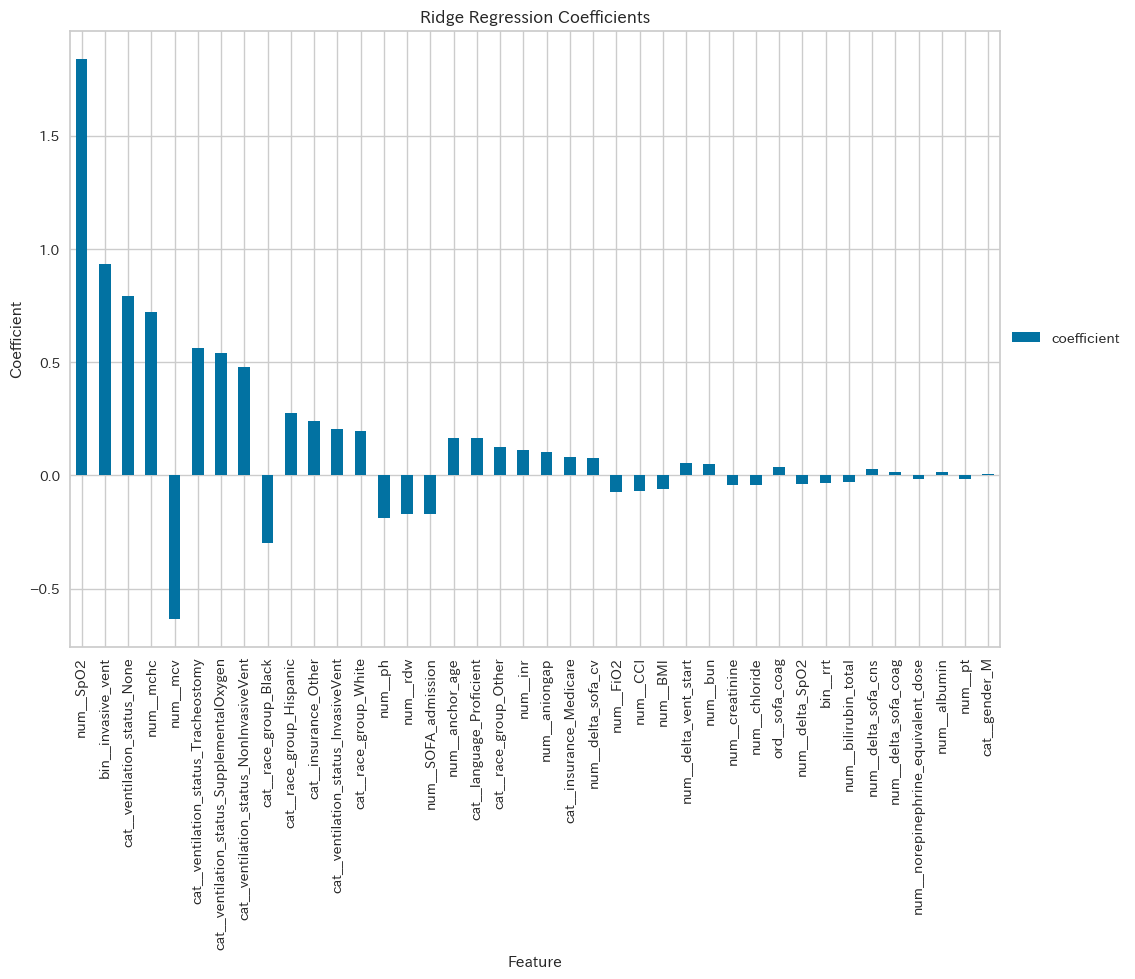

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
ridge_coefficients.plot(kind='bar', ax=ax)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Ridge Regression Coefficients')
plt.show()


では、続いて[残差誤差](https:/www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/regression-and-correlation/residuals.html#:~:text=Definition,yi%E2%88%92%5Eyi)というモデルの誤差を調べてみましょう。

<br/>

We also can explore the errors of the model --called [residuals](https:/www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/regression-and-correlation/residuals.html#:~:text=Definition,yi%E2%88%92%5Eyi).

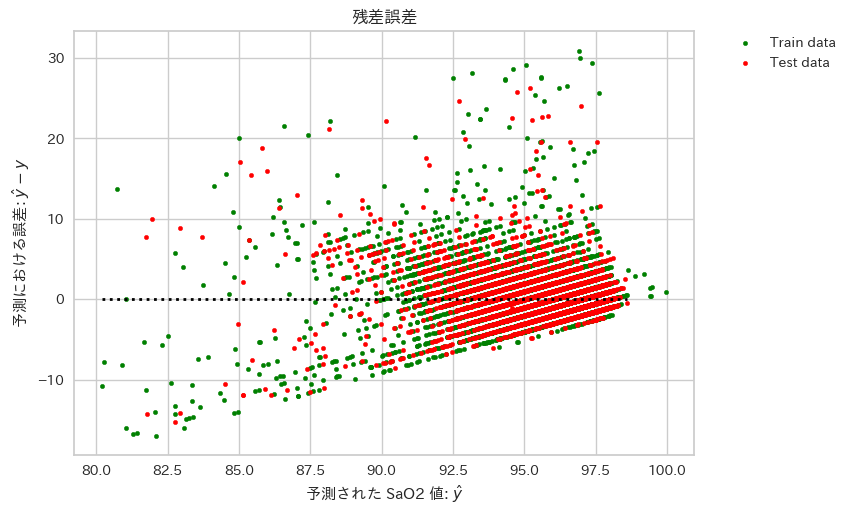

In [ ]:
# Create residual error plot for both training and test data
plt.scatter(ridge_pipeline_regression.predict(X_train), ridge_pipeline_regression.predict(X_train) - y_train_r.ravel(), color = "green", s = 10, label = 'Train data')
plt.scatter(ridge_pipeline_regression.predict(X_test), ridge_pipeline_regression.predict(X_test) - y_test_r.ravel(), color = "red", s = 10, label = 'Test data')

# Draw a horizontal line at y = 0
plt.hlines(y = 0, xmin = ridge_pipeline_regression.predict(X_train).min(), xmax = ridge_pipeline_regression.predict(X_test).max(), linewidth = 2, color="black", linestyle="dotted")

# Add legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)

# Add title and labels
plt.title("残差誤差")
plt.xlabel(r"予測された SaO2 値: $\hat y$")
plt.ylabel(r"予測における誤差: $\hat y  - y$")

# Show the plot
plt.show()


#### 3.2.3 回帰モデルの評価指標

回帰モデルの評価にはしばしば [$R^2$ score](https://en.wikipedia.org/wiki/Coefficient_of_determination) が用いられます。$R^2$ score の取りうる最大値は 1.0 であり、モデルが悪い場合には負になることもあります。真値(真のy)が一意に定まらないケースでは、定数モデルの$R^2$ score は 0.0 となりますが、これは定数モデルが入力特徴を無視して常に平均 y を予測値とするからです。

<br/>
Regression tasks are often evaluated using the [$R^2$ score](https://en.wikipedia.org/wiki/Coefficient_of_determination). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). In the general case when the true y is non-constant, a constant model that always predicts the average y disregarding the input features would get a $R^2$ score of 0.0.

In [ ]:
# Evaluate the linear model with R2 :
y_pred_train_linear = linear_pipeline_regression.predict(X_train)
linear_train_r2 = r2_score(y_train_r, y_pred_train_linear)
print(f'線形モデルの R2 score: {linear_train_r2}')

# Evaluate the ridge model with R2 :
y_pred_train_ridge = ridge_pipeline_regression.predict(X_train)
ridge_train_r2 = r2_score(y_train_r, y_pred_train_ridge)
print(f'リッジ回帰モデルの R2 score: {ridge_train_r2}')

線形モデルの R2 score: 0.3405347977322407
リッジ回帰モデルの R2 score: 0.34044111138212574


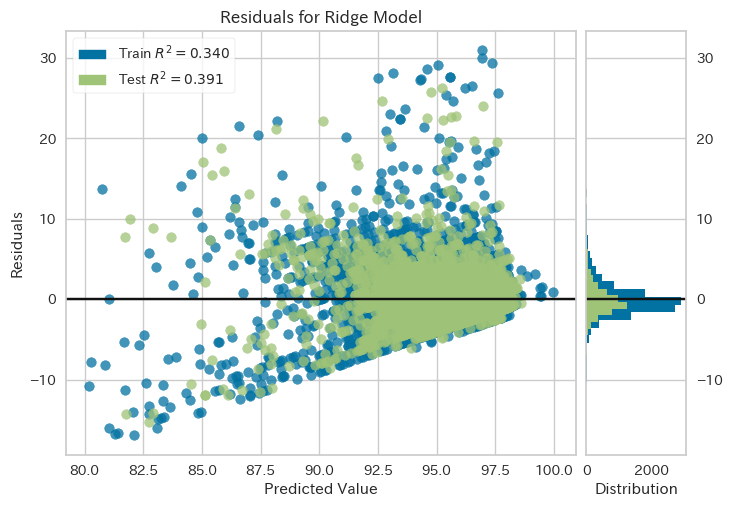

<Axes: title={'center': 'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
visualizer = ResidualsPlot(ridge_pipeline_regression)
visualizer.fit(X_train, y_train_r.ravel())
visualizer.score(X_test, y_test_r.ravel())
visualizer.show()

R2 score: 0.39127397990780954


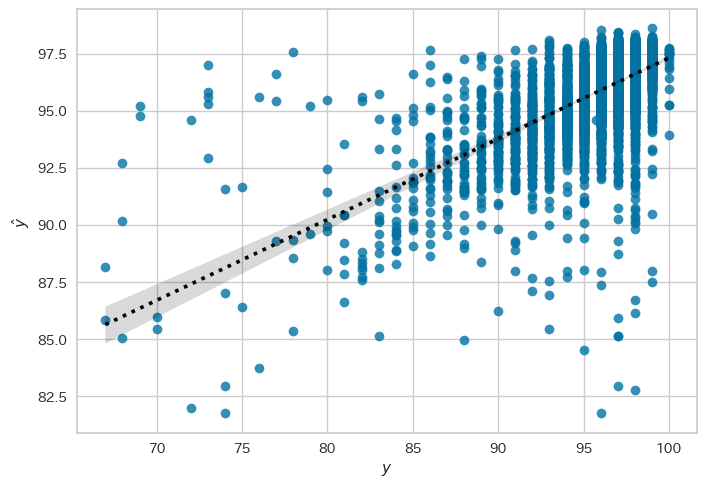

In [ ]:
ridge_pipeline_regression.fit(X_train, y_train_r.ravel())
hat_y_test = ridge_pipeline_regression.predict(X_test)

fig, ax = plt.subplots(1)
sns.regplot(data=None, x=y_test_r, y=hat_y_test, line_kws={"color":"black", "linestyle":"dotted"})
plt.plot()
ax.set(xlabel=r"$y$", ylabel=r"$\hat y$")
test_r2_score_ = r2_score(y_test_r, hat_y_test)
print(f"R2 score: {test_r2_score_}")


✏️ 他にも様々な性能評価指数が[sklearnでは実装されています](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)。今回のタスクについて、より適当だと思われる性能評価指数があれば試してみましょう。\
Different regression metrics are [implemented by sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics). Try another metric that you think is relevant to this problem.

In [ ]:
# CODE here !

##### ※モデルの評価について / Model Evaluation

SpO2値の補正用の機械学習モデルを開発し、臨床に導入するためにはモデルの性能を正しく評価することが必須です。

モデルが使われる臨床の環境だけでなく、学習に使用したデータセットのことも考慮して性能評価のための指標(メトリクス: Metrics)を慎重に選択する必要があります。

> 考慮すべき点の例
- 学習に用いられた名義変数に含まれていない名義変数を持つ患者に対してはどのような性能を示すだろうか
- 学習データに含まれる変数の中で、特定の範囲に偏ったものはないだろうか

<br/>

To be able to develop an ML model for the recalibration of SpO2 levels and implement it in a clinical setting, it is crucial to properly evaluate its performance in the task that is supposed to do.

A set of performance metrics should be carefully chosen, considering the clinical setting where the model will be aplied in but also the dataset where is what trained on:
- If the dataset contains mostly one racial group, how will it perform on others patients?
- Does the dataset have patients from a wide range of ages or is it more focused on a narrow range?


先の線形モデルやリッジ回帰線形モデルの $R^2$ score はあまり満足のいくものではありませんでした。これについては以下の二つの説明が考えられます。
1. 目的変数に対して十分な説明変数を持っていない
2. 目的変数が線形の関係にない

✏️ $R^2$ score で評価する場合、よりよい回帰モデルを挙げることができますか？例えば「[決定木](https://scikit-learn.org/stable/modules/tree.html#regression)」や「[アンサンブル モデル](https://scikit-learn.org/stable/modules/ensemble.html)」はどうでしょうか。もちろん、他のタイプの線形アルゴリズムについても自由に試してみてください。

<br/>

We saw that the regression metrics of both the linear regression and the regularized linear ridge regressions are not very satisfying. There are two explanations: either, we have not the proper variables to explain the output variables or these variables do not relate to the SaO2 with a pure linear relationship.

✏️  Can you fit and evaluate a better regression model in term of $R^2$ ? Consider for example [decision trees](https://scikit-learn.org/stable/modules/tree.html#regression) or [ensemble models](https://scikit-learn.org/stable/modules/ensemble.html). But feel free to experiment with any other type of regression algorithms !

Best Parameters:  {'regressor__num_leaves': 7, 'regressor__n_estimators': 200, 'regressor__max_depth': -1, 'regressor__learning_rate': 0.05, 'regressor__lambda_l2': 1.0, 'regressor__lambda_l1': 10.0, 'regressor__bagging_freq': 5, 'regressor__bagging_fraction': 1.0}
Best Score:  0.3662311795568014


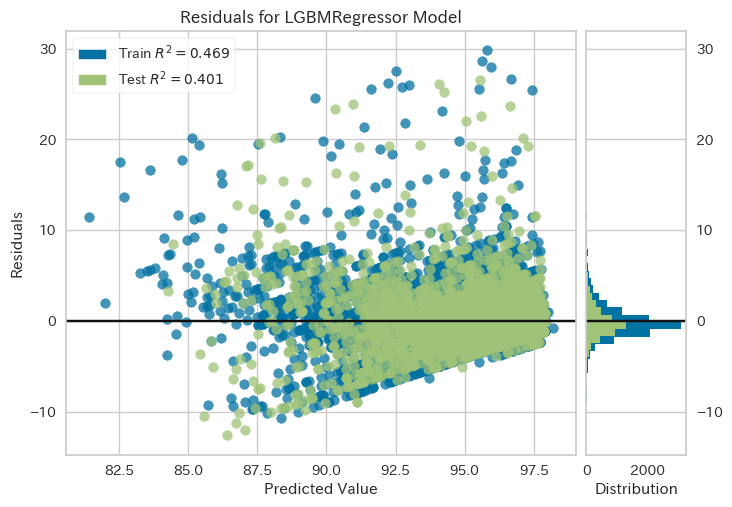

LightGBMモデルの R2 score (テストデータ) with Best Parameters: 0.4013670853599931
LightGBMを用いて算出した特徴の重要度: 


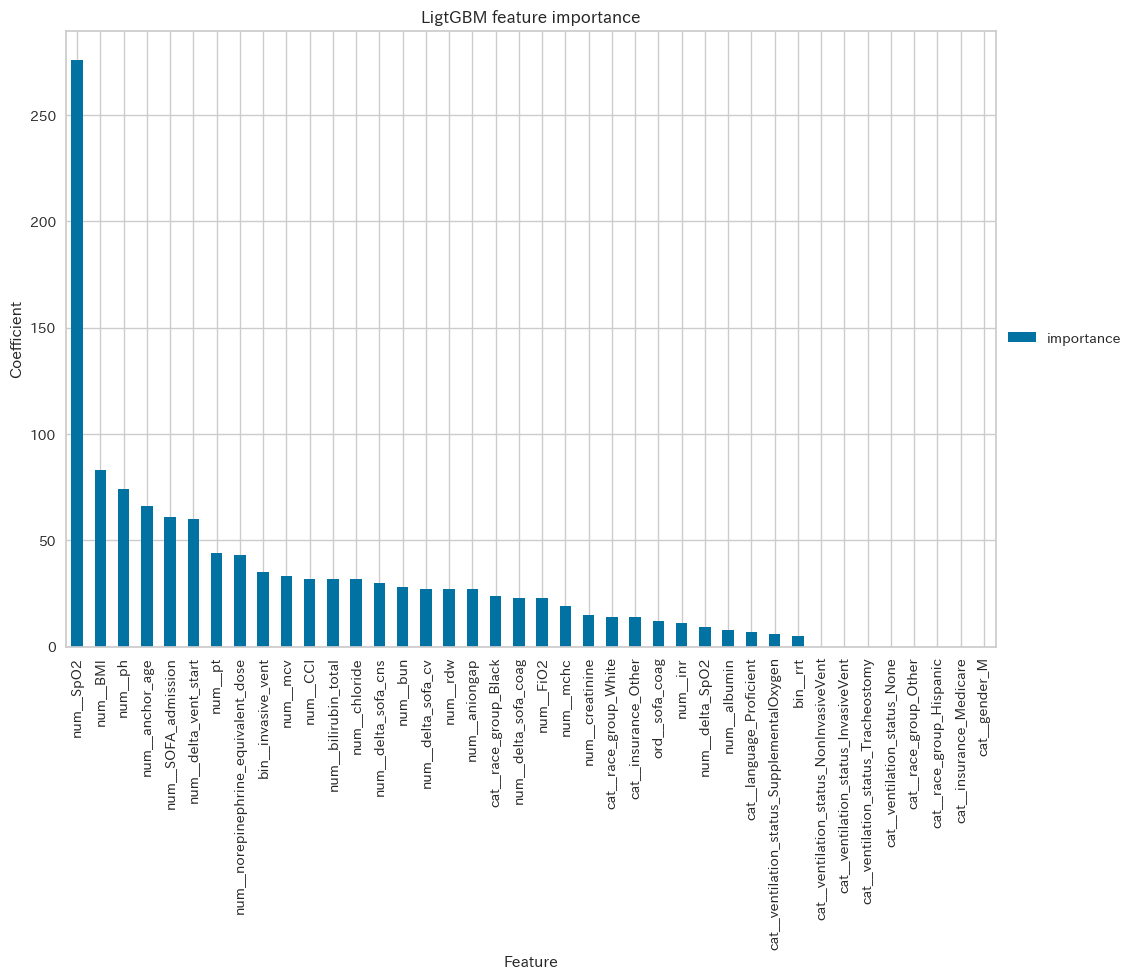

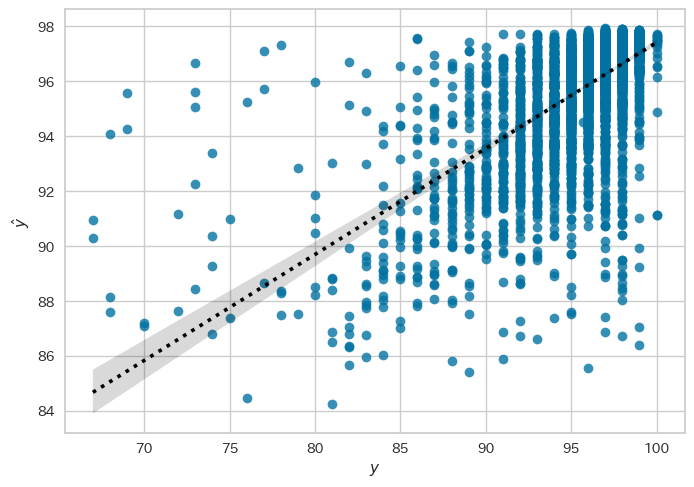

In [ ]:
# CODE here !
# LightGBM を用いた例

import lightgbm as lgb
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from yellowbrick.regressor import ResidualsPlot

# 前処理とLightGBMを組み合わせたパイプライン
lgbm_pipeline_regression = Pipeline([
    ('custom_transform', CustomTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(
        num_leaves=31,
        max_depth=10,
        learning_rate=0.05,
        n_estimators=100,
        lambda_l1=0.1,
        lambda_l2=0.1,
        bagging_fraction=0.7,
        bagging_freq=5,
        verbose=-1
    ))
])

# パラメータの探索空間の定義
param_dist = {
    'regressor__num_leaves': [7, 15, 31, 63, 127],
    'regressor__max_depth': [-1, 5, 10, 15, 20],
    'regressor__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__lambda_l1': np.logspace(-5, 2, 8),
    'regressor__lambda_l2': np.logspace(-5, 2, 8),
    'regressor__bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__bagging_freq': [1, 5, 10, 20]
}

# ランダムサーチの設定と実行
search = RandomizedSearchCV(
    lgbm_pipeline_regression,
    param_distributions=param_dist,
    n_iter=50,                    # 探索するパラメータの組み合わせの数
    scoring='r2',                 # R2スコアでモデルを評価
    cv=5,                           # 5-fold交差検証を使用
    verbose=-1,                  # 実行中のログ表示レベル
    n_jobs=-1,                   # すべてのCPUコアを使用
    random_state=0          # 再現性を確保するための乱数のシード
)

# ランダムサーチの実行
search.fit(X_train, y_train_r.ravel())

# 最適なハイパーパラメータとその時の交差検証の平均スコアを表示
print("Best Parameters: ", search.best_params_)
print("Best Score: ", search.best_score_)

# ベストなモデルでテストデータの残差プロット
best_lgbm = search.best_estimator_
visualizer = ResidualsPlot(best_lgbm)
visualizer.fit(X_train, y_train_r.ravel())
visualizer.score(X_test, y_test_r.ravel())
visualizer.show()

# ベストモデルでテストデータに対するR2を計算
hat_y_test_lgbm = best_lgbm.predict(X_test)
test_r2_score_lgbm = r2_score(y_test_r, hat_y_test_lgbm)
print(f"LightGBMモデルの R2 score (テストデータ) with Best Parameters: {test_r2_score_lgbm}")

# 特徴の重要度の取得
lgbm_feature_importance = pd.DataFrame(
    best_lgbm.named_steps['regressor'].feature_importances_,
    index=feature_names,
    columns=['importance']
).sort_values(by='importance', ascending=False)

print('LightGBMを用いて算出した特徴の重要度: ')
lgbm_feature_importance = pd.DataFrame(
    best_lgbm.named_steps['regressor'].feature_importances_,
    index=feature_names,
    columns=['importance']
).sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
lgbm_feature_importance.plot(kind='bar', ax=ax)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('LigtGBM feature importance')
plt.show()


# 散布図のプロット
fig, ax = plt.subplots(1)
sns.regplot(x=y_test_r, y=hat_y_test_lgbm, line_kws={"color":"black", "linestyle":"dotted"})
ax.set(xlabel=r"$y$", ylabel=r"$\hat y$")
plt.show()

### 3.3 分類モデルを作ってみよう

ここでは、訓練データを使用して、与えられた特徴量から `hidden_hypoxemia` を予測する分類モデルを作成し、テストデータの `hidden_hypoxemia` を予測してみます。

#### 3.3.1 SVM分類のベースライン / SVM Classification Baseline

世の中には分類のタスクに用いられるモデルが多くあります。\
私たちはその中からタスクに応じて最適なものを選択する必要があります。\
ここではそのようなモデルの一つ、サポートベクタマシーン(SVM)の実装を引き合いに出します。

モデルを訓練するに先んじて、ロバストで正確なモデルを構築するうえで非常に重要となるパラメータ、ハイパパラメータを設定する必要があります。

ハイパパラメータ(\*)はバイアスと共分散の均衡点を見つけるのに役立つだけでなく、モデルの過学習(Overfitting)や学習不足(Underfitting)を防止することにも役立ちます。\
<[詳細はこちら](https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167)>

> \*ハイパーパラメーター: \
> ハイパーパラメーターは、モデルの訓練中にデータから学習されないパラメーターであり、訓練プロセスの前に設定されます。学習アルゴリズムの構造や動作を決定します。ハイパーパラメーターの調整は、学習アルゴリズムのパフォーマンスに大きく影響するため、ハイパーパラメーターのチューニングは機械学習モデルを構築する際の重要なステップとなります。

<br/>

For the classification task, you might choose from a wide range of models that you think are most suitable. Here you have the example of the implementation of a Support Vector Machine (SVM).

Before training the model, we need to set a given number of parameters - i.e. hyperparameters - which will be critical in building robust and accurate models. They help us find the balance between bias and variance and thus, prevent the model from overfitting or underfitting.Keep in mind that if you increase the range of hyperparameters to be tested, the training time will increase significantly. If you want more information read [here](https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167).

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        if 'rrt' in X_.columns:
            X_["rrt"] = X_["rrt"].replace({"None": 0}).astype(float)
        if 'sofa_coag' in X_.columns:
            X_["sofa_coag"] = X_["sofa_coag"].replace({"None": -1}).astype(float)
        return X_

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# 前処理のためのパイプラインを作成する
binary_vars = ['invasive_vent', 'rrt']
categorical_vars = ['gender', 'insurance', 'race_group', 'language', 'ventilation_status']
ordinal_vars = ['sofa_coag']
continuous_vars = [col for col in df_train.columns if col not in binary_vars + categorical_vars + ordinal_vars + ['subject_id', 'stay_id', 'SaO2', 'hidden_hypoxemia']]

X_train = df_train.drop(columns=['SaO2', 'subject_id', 'stay_id', 'hidden_hypoxemia'])
X_test = df_test.drop(columns=['SaO2', 'subject_id', 'stay_id', 'hidden_hypoxemia'])

preprocessor = ColumnTransformer(
    transformers=[
        ('bin', 'passthrough', binary_vars),
        ('cat', OneHotEncoder(drop='first'), categorical_vars),
        ('ord', OrdinalEncoder(), ordinal_vars),
        ('num', StandardScaler(), continuous_vars)
    ]
)

In [ ]:
# 注意：ここでは説明のため、実際にはハイパーパラメータチューニングを行っていません。

# 前処理とSVCを組み合わせたパイプライン
svc_pipeline_classifier = Pipeline([
    ('custom_transform', CustomTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# ハイパーパラメータの設定
param_grid = {
    'classifier__C': [1.0],
    'classifier__gamma': ['scale'],
    'classifier__kernel': ['rbf']
}

# グリッドサーチの設定
svc_grid_search = GridSearchCV(
    svc_pipeline_classifier,
    param_grid,
    scoring="accuracy",
    refit = True,
    verbose = 3,
)

# モデルの訓練
svc_grid_search.fit(X_train, y_train_c.ravel())

# 予測
svc_predictions = svc_grid_search.predict(X_test)

# スコアの表示
print('SVC Score: {}'.format(svc_grid_search.score(X_test, y_test_c.ravel())))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__C=1.0, classifier__gamma=scale, classifier__kernel=rbf;, score=0.984 total time=   8.6s
[CV 2/5] END classifier__C=1.0, classifier__gamma=scale, classifier__kernel=rbf;, score=0.984 total time=   4.6s
[CV 3/5] END classifier__C=1.0, classifier__gamma=scale, classifier__kernel=rbf;, score=0.984 total time=   4.7s
[CV 4/5] END classifier__C=1.0, classifier__gamma=scale, classifier__kernel=rbf;, score=0.984 total time=   6.4s
[CV 5/5] END classifier__C=1.0, classifier__gamma=scale, classifier__kernel=rbf;, score=0.984 total time=   4.6s
SVC Score: 0.9827650805545148


ご覧の通り、スコアはほぼ100%です！問題ないでしょうか？
きちんと分類できているか、混同行列(Confusion Matrix)を見てみましょう。

As you can observe, the scoring is almost 100%! Great, right? \
Well, let's take a closer look at the confusion matrix for a deeper analysis:

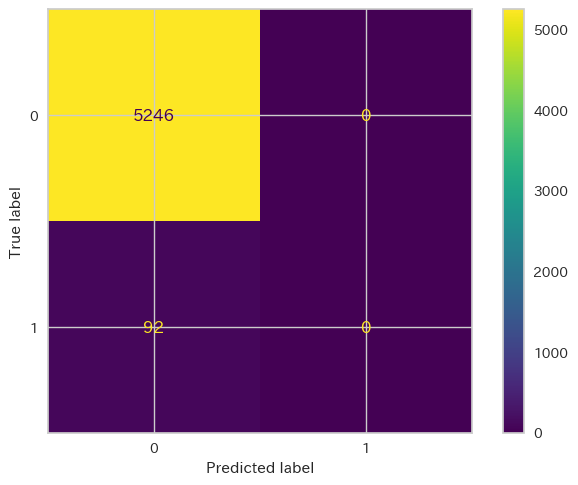

In [ ]:
#Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test_c, svc_predictions))
cm_display.plot()
plt.show()

In [ ]:
# check balance
num_of_hidden_hypoxemia = (df_train['hidden_hypoxemia']==1).sum()
num_of_normal= (df_train['hidden_hypoxemia']==0).sum()
print(f"{num_of_hidden_hypoxemia} measurements with hidden hypoxia / {num_of_normal} normal ones")

190 measurements with hidden hypoxia / 11641 normal ones


13,691件の正常な測定値(= 潜在性低酸素血症でない)のデータに対し、220件しか潜在性低酸素血症であるデータはありません。これは非常に不均衡なデータセットと言えるでしょう。では、どのように対処しましょう？

<br />

このような不均衡なデータセットに対してはいくつかの対処法が存在します。

*   多数派のデータ数を少数派のデータ数に合わせる
> この手法は単純ですが、多くの貴重なデータを損失することに繋がります。

<br />

*   少数派のデータに対してSMOTEアルゴリズムなどを用いてアップサンプリングを行い、合成データを作成する
> この手法では、少数派クラスの各変数についてその分散を単に維持してしまうという問題があり、最も良い方法とは言えないかもしれません。

<br />

* 不均衡データに適応したアルゴリズムを使う。
> 例えば [Imbalanced Learn](https://imbalanced-learn.org/stable/) という sklearn とよく似たパッケージがあります。これはSVMを含むほとんどの sklearn のアルゴリズムの class_weight パラメータに不均衡クラスが追加されています。

不均衡データについてより詳しく知りたい方は[こちら](https://medium.com/eni-digitalks/imbalanced-data-an-extensive-guide-on-how-to-deal-with-imbalanced-classification-problems-6c8df0bc2cab)からご覧ください。

<br/>

It looks like we have a really imbalanced dataset, where we have only 1,104 measurements with hidden hypoxia compared to 55,190 normal ones. What should we do then?

One can take several approaches when dealing with imbalanced datasets:
- removing the number of datapoints for the majority class to match the number on the minority class. However, this might lead you to loose a lot of information.
- upsample the minority class and generate synthetic data on it, using for example the SMOTE algorithm. This approach has the problem of maintaining the distribution of each variable for that class and might not provide the best results.
- another approach might be to use an algorithm approppriate for this type of data. For that, there is a package very similar to sklearn called [Imbalanced Learn](https://imbalanced-learn.org/stable/) and add the class imbalance to the class_weight parameter in most sklearn algorithms (including in [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

You can read more about it [here](https://medium.com/eni-digitalks/imbalanced-data-an-extensive-guide-on-how-to-deal-with-imbalanced-classification-problems-6c8df0bc2cab).

#### 3.3.2 Random Forest Classifier / ランダムフォレスト分類器

続いて、 Random Forest Classifier (RFC: ランダムフォレスト分類器) を用いたモデルを作成してみましょう。<br>
RFC は、複数の決定木を学習し、それらの結果の多数決や平均によって最終的な予測を行う、アンサンブル学習の手法一つです。<br>
RFC については[こちら](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)に詳細な説明があります。

Next, let's create a model using the Random Forest Classifier (RFC). The RFC is a type of ensemble learning method that makes a final prediction based on the majority vote or average of the results obtained from multiple decision trees. For a detailed explanation of RFC, please refer to [this link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 前処理とRandomForestClassifierを組み合わせたパイプライン
rfc_pipeline_classifier = Pipeline([
    ('custom_transform', CustomTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight="balanced"))
])


# パラメータの設定
param_dist = {
    'classifier__n_estimators': np.arange(50, 200),  # ツリーの数
    'classifier__max_depth': [None] + list(np.arange(2, 20)),  # ツリーの最大深度
    'classifier__min_samples_split': np.arange(2, 20),  # ノードを分割するために必要な最小サンプル数
    'classifier__min_samples_leaf': np.arange(1, 20),  # 葉ノードに必要な最小サンプル数
}

# ランダムサーチの設定
rfc_random_search = RandomizedSearchCV(
    rfc_pipeline_classifier,
    param_distributions=param_dist,
    refit=True,
    verbose=3,
    n_iter=5,
    cv=5,
    scoring='f1',
    random_state=42
)

# モデルの訓練
rfc_random_search.fit(X_train, y_train_c.ravel())

# 予測
rfc_predictions = rfc_random_search.predict(X_test)

# スコアの表示
print('RFC Score: {}'.format(rfc_random_search.score(X_test, y_test_c.ravel())))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END classifier__max_depth=3, classifier__min_samples_leaf=8, classifier__min_samples_split=5, classifier__n_estimators=58;, score=0.123 total time=   0.4s
[CV 2/5] END classifier__max_depth=3, classifier__min_samples_leaf=8, classifier__min_samples_split=5, classifier__n_estimators=58;, score=0.078 total time=   0.4s
[CV 3/5] END classifier__max_depth=3, classifier__min_samples_leaf=8, classifier__min_samples_split=5, classifier__n_estimators=58;, score=0.096 total time=   0.4s
[CV 4/5] END classifier__max_depth=3, classifier__min_samples_leaf=8, classifier__min_samples_split=5, classifier__n_estimators=58;, score=0.134 total time=   0.4s
[CV 5/5] END classifier__max_depth=3, classifier__min_samples_leaf=8, classifier__min_samples_split=5, classifier__n_estimators=58;, score=0.116 total time=   0.4s
[CV 1/5] END classifier__max_depth=14, classifier__min_samples_leaf=2, classifier__min_samples_split=12, classifier__n_e

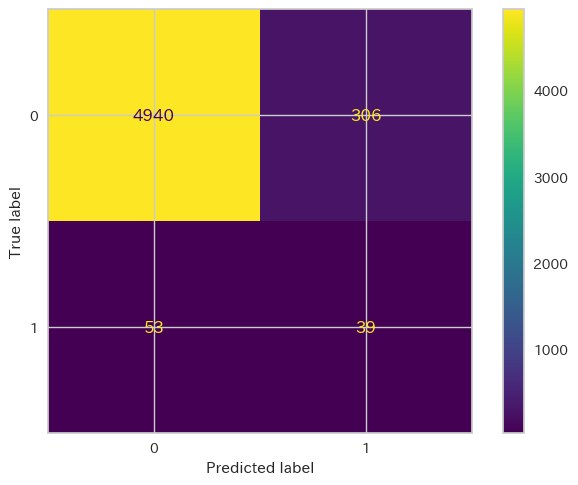

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test_c, rfc_predictions))
cm_display.plot()
plt.show()

#### 3.3.3 分類モデルの評価指標

分類モデルについても評価指標を見てみましょう。<br>
分類モデルの評価指標として、混同行列に基づく様々な指標が知られています。<br>
代表的なものは、 accuracy（精度）や precision（適合率）、recall （再現率）、 F1 スコアなどがあります。<br>
これらの指標はそれぞれ異なる性質を持っています。<br>
accuracy は、全体の予測の正確さを示しますが、データのクラスの不均衡がある場合には適切な評価指標とはなりません。<br>
precision は、正と予測したものの中で実際に正であるものの割合を表し、 recall は実際に正であるものの中で正と予測できたものの割合を示します。<br>
F1スコアは適合率と再現率の調和平均で、両者のバランスを取る指標として利用されます。<br>


Let's also take a look at evaluation metrics for classification models. <br>
There are various metrics known for evaluating classification models, many of which are based on the confusion matrix. <br>
Prominent among these are accuracy, precision, recall, and the F1 score.
<br>
These metrics each have different characteristics. <br>
Accuracy represents the overall correctness of the predictions, but it is not an appropriate evaluation metric when there is class imbalance in the data. <br>
Precision represents the proportion of the instances predicted as positive that are actually positive, while recall represents the proportion of actual positive instances that were correctly predicted as such. <br>
The F1 score is the harmonic mean of precision and recall and is used as a metric to balance the two.






Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


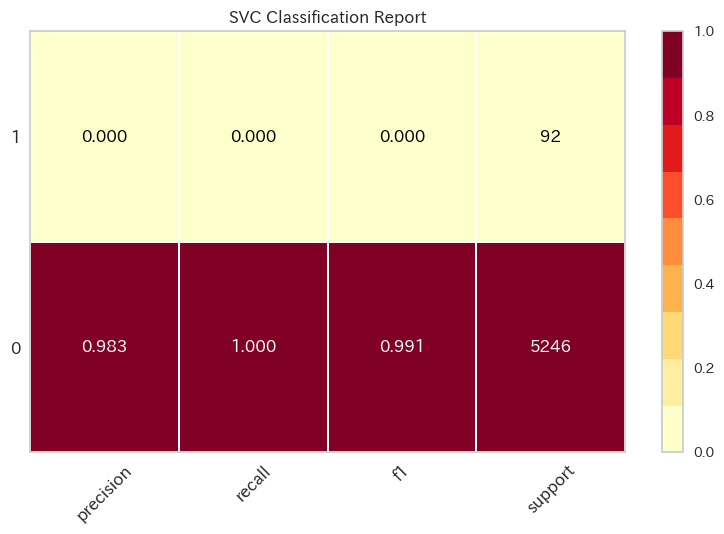

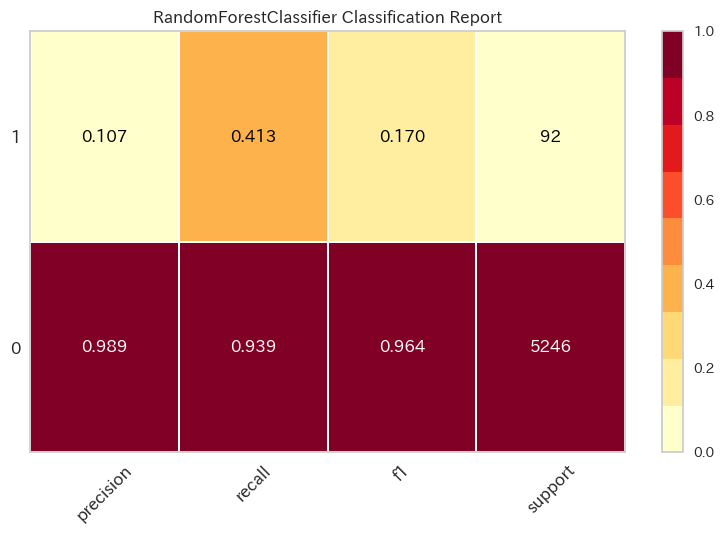

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [ ]:
# SVCのClassificationReport
svc_visualizer = ClassificationReport(svc_grid_search.best_estimator_, classes=[0,1], support=True)

# 訓練データでモデルのfitを行い、テストデータでスコアを計算
svc_visualizer.fit(X_train, y_train_c.ravel())
svc_visualizer.score(X_test, y_test_c.ravel())
svc_visualizer.show()

# RandomForestClassifierのClassificationReport
rfc_visualizer = ClassificationReport(rfc_random_search.best_estimator_, classes=[0,1], support=True)

# 訓練データでモデルのfitを行い、テストデータでスコアを計算
rfc_visualizer.fit(X_train, y_train_c.ravel())
rfc_visualizer.score(X_test, y_test_c.ravel())
rfc_visualizer.show()


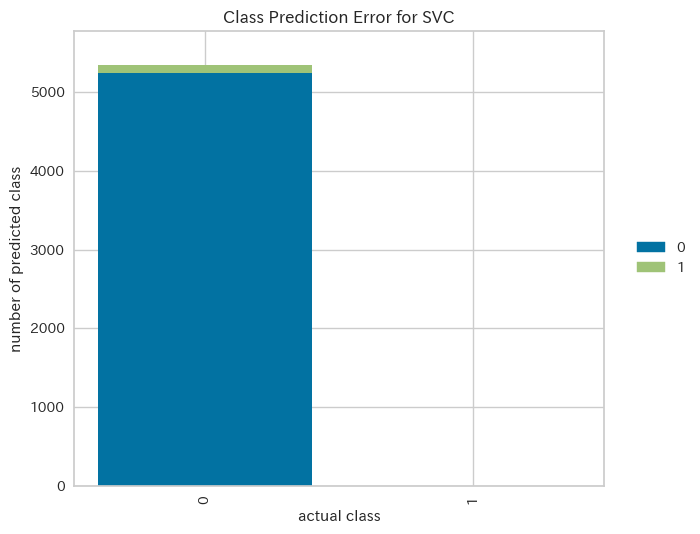

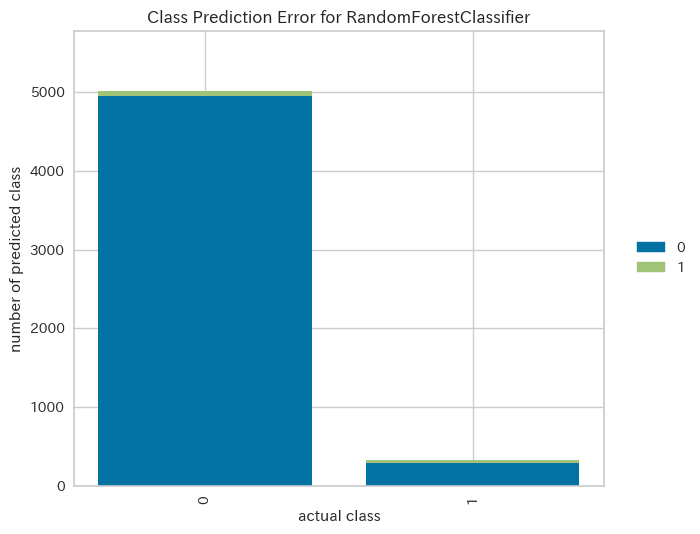

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
# SVCのClassPredictionError
svc_cpe_visualizer = ClassPredictionError(svc_grid_search.best_estimator_, classes=[0,1])

# 訓練データでモデルのfitを行い、テストデータでスコアを計算
svc_cpe_visualizer.fit(X_train, y_train_c.ravel())
svc_cpe_visualizer.score(X_test, y_test_c.ravel())
svc_cpe_visualizer.show()

# RandomForestClassifierのClassPredictionError
rfc_cpe_visualizer = ClassPredictionError(rfc_random_search.best_estimator_, classes=[0,1])

# 訓練データでモデルのfitを行い、テストデータでスコアを計算
rfc_cpe_visualizer.fit(X_train, y_train_c.ravel())
rfc_cpe_visualizer.score(X_test, y_test_c.ravel())
rfc_cpe_visualizer.show()


##### PR-AUCについて / PR-AUC
PR-AUC (Precision-Recall Area Under the Curve)は、Precision-Recall曲線（適合率-再現率曲線）の下の面積を計測する評価指標です。不均衡なデータセットに対するモデルの性能を評価する際に、よく使用されます。PR曲線は、異なる閾値設定でのモデルの適合率と再現率の関係をプロットしたもので、PR-AUCはこの曲線下の面積を示します。値が1に近いほど、モデルの性能が高いと評価されます。<br>
PR-AUCについて、詳細な説明は[こちらのページ](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)も参考にしてください。

PR-AUC (Precision-Recall Area Under the Curve) is an evaluation metric that measures the area under the Precision-Recall curve. It is often used to evaluate the performance of a model on imbalanced datasets. The Precision-Recall curve plots the relationship between the model's precision and recall at different threshold settings, and the PR-AUC represents the area under this curve. The closer the value is to 1, the higher the model's performance is evaluated.
 If you want more information read [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html).

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

# SVCモデルからの予測確率を取得
svc_probs = svc_grid_search.predict_proba(X_test)[:, 1]

# RFCモデルからの予測確率を取得
rfc_probs = rfc_random_search.predict_proba(X_test)[:, 1]

# 評価指標を計算
svc_f1 = f1_score(y_test_c.ravel(), svc_predictions)
svc_roc_auc = roc_auc_score(y_test_c.ravel(), svc_probs)
svc_pr_auc = average_precision_score(y_test_c.ravel(), svc_probs)

rfc_f1 = f1_score(y_test_c.ravel(), rfc_predictions)
rfc_roc_auc = roc_auc_score(y_test_c.ravel(), rfc_probs)
rfc_pr_auc = average_precision_score(y_test_c.ravel(), rfc_probs)

# 結果を出力
print("SVC Metrics:")
print(f"F1 Score: {svc_f1}")
print(f"ROC-AUC: {svc_roc_auc}")
print(f"PR-AUC: {svc_pr_auc}")

print("\nRFC Metrics:")
print(f"F1 Score: {rfc_f1}")
print(f"ROC-AUC: {rfc_roc_auc}")
print(f"PR-AUC: {rfc_pr_auc}")


SVC Metrics:
F1 Score: 0.0
ROC-AUC: 0.7076488919093638
PR-AUC: 0.07171572951775149

RFC Metrics:
F1 Score: 0.17848970251716245
ROC-AUC: 0.8450662202257622
PR-AUC: 0.1155337013696448


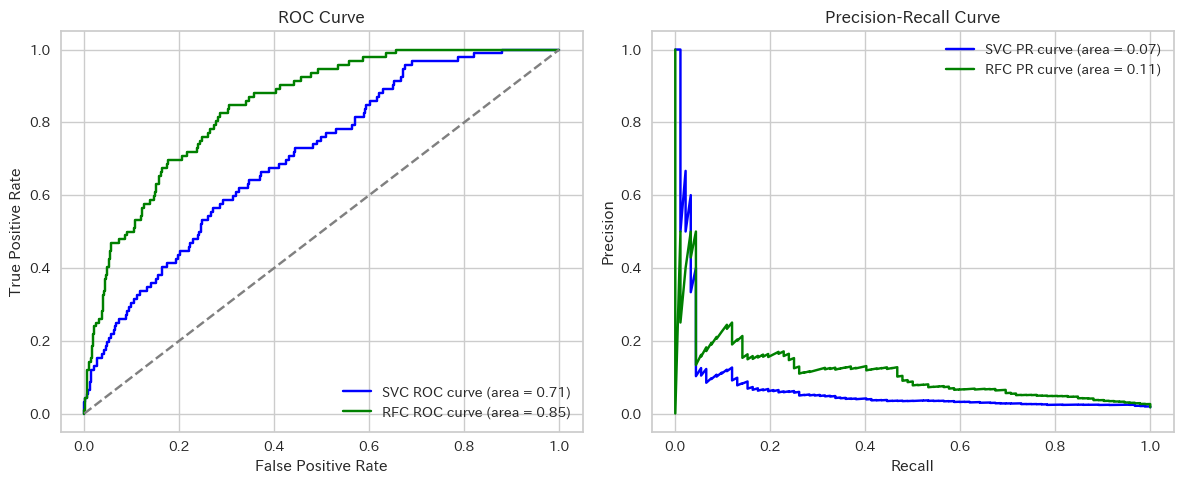

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC curveの計算
fpr_svc, tpr_svc, _ = roc_curve(y_test_c.ravel(), svc_probs)
roc_auc_svc = auc(fpr_svc, tpr_svc)

fpr_rfc, tpr_rfc, _ = roc_curve(y_test_c.ravel(), rfc_probs)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

# PR curveの計算
precision_svc, recall_svc, _ = precision_recall_curve(y_test_c.ravel(), svc_probs)
pr_auc_svc = auc(recall_svc, precision_svc)

precision_rfc, recall_rfc, _ = precision_recall_curve(y_test_c.ravel(), rfc_probs)
pr_auc_rfc = auc(recall_rfc, precision_rfc)

# 可視化
plt.figure(figsize=(12, 5))

# ROC curveの可視化
plt.subplot(1, 2, 1)
plt.plot(fpr_svc, tpr_svc, color='blue', label=f'SVC ROC curve (area = {roc_auc_svc:.2f})')
plt.plot(fpr_rfc, tpr_rfc, color='green', label=f'RFC ROC curve (area = {roc_auc_rfc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# PR curveの可視化
plt.subplot(1, 2, 2)
plt.plot(recall_svc, precision_svc, color='blue', label=f'SVC PR curve (area = {pr_auc_svc:.2f})')
plt.plot(recall_rfc, precision_rfc, color='green', label=f'RFC PR curve (area = {pr_auc_rfc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


#### 3.3.4 ✏️ 適切な方法でモデルを評価してみましょう / Properly evaluate your model


In [ ]:
# Code here!

### 3.4 オリジナルモデルの作成 / Your model

ここまでに学んだモデル作成に関する知識を用いて、潜在性低酸素血症を予測するのに最も適切と思われるフレームワークを選び、モデルを作成しましょう。

必要であれば本ノートブック内のコードを自由に使ってもらって構いません。

<br/>

Use the insigths learned from the models previously presented to build your own model with the framework you think is most suitable. You are free to use any of the code presented in the notebook.

###### 3.4.1 ✏️ オリジナルモデルを作成しよう /  Implement your model

In [ ]:
# Code here!

## 4. 特徴量の重要度 / Feature Importance

テストデータについてSHAP値を計算してみましょう。

Compute the SHAP values for the test data.

 99%|===================| 10595/10676 [01:53<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


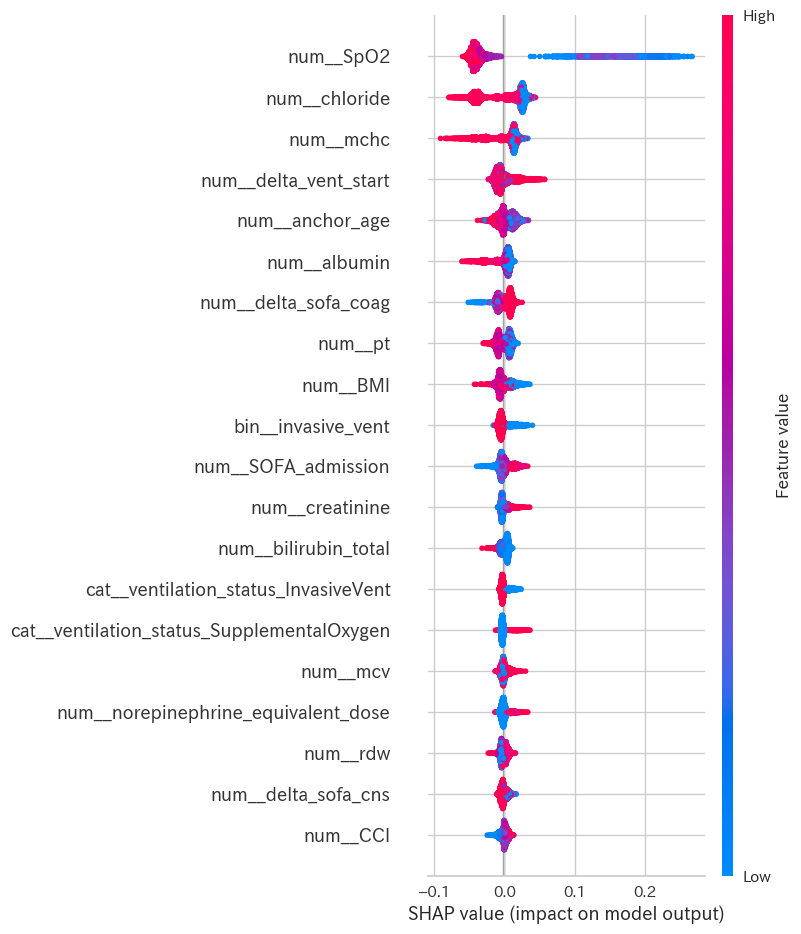

In [ ]:
import shap

# モデルと前処理データを取得
rfc_model = rfc_random_search.best_estimator_.named_steps['classifier']
fitted_custom_transform = rfc_random_search.best_estimator_.named_steps['custom_transform']
fitted_preprocessor = rfc_random_search.best_estimator_.named_steps['preprocessor']

# データを前処理
X_train_transformed = fitted_custom_transform.transform(X_train)
X_train_preprocessed = fitted_preprocessor.transform(X_train_transformed)

X_test_transformed = fitted_custom_transform.transform(X_test)
X_test_preprocessed = fitted_preprocessor.transform(X_test_transformed)

# 事前のデータセットを取得
background_data = shap.sample(X_train_preprocessed, 100)  # 100のインスタンスを使用

# TreeExplainerを作成
explainer = shap.TreeExplainer(rfc_model, background_data, check_additivity=False)

# SHAP値をテストデータで計算
shap_values_test = explainer.shap_values(X_test_preprocessed, check_additivity=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    return column_transformer.get_feature_names_out()

# フィット済みのColumnTransformerから特徴名を取得
fitted_feature_names = fitted_preprocessor.get_feature_names_out()

# この新しい特徴名リストでSHAPの要約プロットを表示
shap.summary_plot(shap_values_test[1], X_test_preprocessed, feature_names=fitted_feature_names)


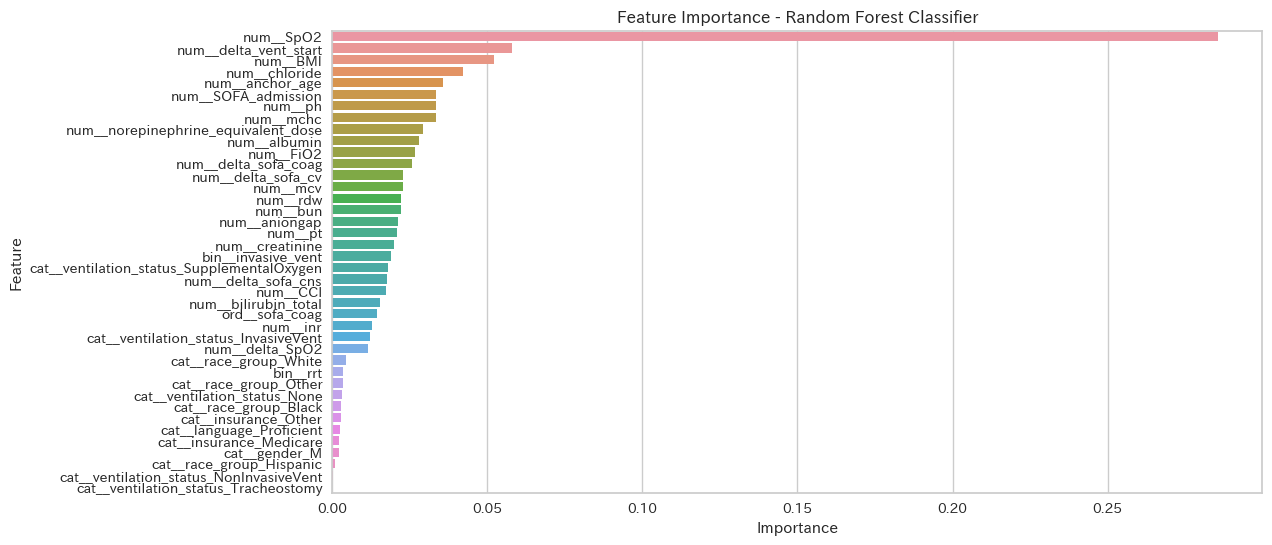

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Random Forest Classifier の場合、 feature importance を取得することが可能

# モデルから最良のランダムフォレスト分類器を取得
best_rfc = rfc_random_search.best_estimator_.named_steps['classifier']

# 特徴量の名前を取得（前処理の情報も含めるため、'preprocessor'を通して取得）
features = rfc_random_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# 特徴量の重要度を取得
feature_importance = best_rfc.feature_importances_

# 重要度をデータフレームに変換
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# 重要度の降順にソート
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# プロット
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## 5. 交差検証 / Cross validation

交差検証（クロスバリデーション）は、モデルの汎化能力を評価するための手法の一つです。データセットを複数のサブセット（通常は等分）に分割し、そのうちの一つを検証用セットとして残りを訓練セットとして利用します。この過程を各サブセットに対して繰り返すことで、全てのデータが一度は検証セットとして用いられ、モデルの性能をより信頼性高く評価することができます。代表的な交差検証法にはk-分割交差検証があります。詳細は[こちらのページ](https://scikit-learn.org/stable/modules/cross_validation.html)を参考にしてください。

Cross-validation is a technique used to evaluate the generalization ability of a model. It involves dividing the dataset into several subsets (usually equal parts), using one as the test set and the rest as the training set. By repeating this process for each subset, all data are used at least once as a test set, enabling a more reliable evaluation of the model's performance. A popular method of cross-validation is k-fold cross-validation. For more information, please read [this page](https://scikit-learn.org/stable/modules/cross_validation.html).

In [ ]:
# Code here!

## Acknowledgement
日本語訳 (Translation):齋藤 幸史郎 (Koshiro Saito)